# Task 1 
In this task, ConvNext model will be used to perform multi-class classification. First a config file will be created containing the hyperparameters of the experiment. Then a script will be executed to initiate the training process and the model checkpoint will be saved. Finally, ROC curve and AUC score will be calculated. 





## Dataset preparation

Dataset has been split in the following way:
- Train set and val set are obtained from the train directory, `Subset` class is used to split the data in the train directory in 95:5 ratio
- The test set is created from the val directory

More can be found on `utils/dataset.py`


In [8]:
from torchvision import transforms
import os
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import DatasetFolder
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from sklearn.metrics import roc_curve, auc
import torch.nn.functional as F 
from utils import get_model, generate_model_outputs, get_test_dataloader_t1

In [2]:
def sample_loader(f: str):
    return (
        np.load(
            f,
        )
        .astype("float32")
        .transpose(1, 2, 0)
    )


def prepare_dataset_t1(root_dir: str, loader=sample_loader):
    transform = transforms.Compose([transforms.ToTensor(), transforms.CenterCrop(100)])
    dataset = DatasetFolder(
        root=root_dir, extensions=".npy", loader=loader, transform=transform
    )
    return dataset


def get_train_val_dataloader_t1(root_dir: str, batch_size: int = 16, shuffle=True):
    train_val_dir = os.path.join(root_dir, "train")

    train_val_dataset = prepare_dataset_t1(train_val_dir, loader=sample_loader)
    targets = train_val_dataset.targets
    train_idx, val_idx = train_test_split(
        np.arange(len(targets)), test_size=0.05, shuffle=True, stratify=targets
    )

    # Define sampler for train and validation sets
    train_ds = Subset(train_val_dataset, indices=train_idx)
    val_ds = Subset(train_val_dataset, indices=val_idx)

    # Define data loaders
    train_loader = DataLoader(
        train_ds, batch_size=batch_size, shuffle=False
    )
    val_loader = DataLoader(
        val_ds, batch_size=batch_size, shuffle=False
    )

    return train_loader, val_loader


def get_test_dataloader_t1(root_dir: str, batch_size: int = 16, shuffle = False, for_notebook = False):
    test_dir = os.path.join(root_dir, "val")
    test_dataset = prepare_dataset_t1(test_dir, loader=sample_loader)
    if for_notebook : 
        batch_size = len(test_dataset)

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)

    return test_loader

## Create config file

In [3]:
conf = """


exp:
  cache: 2
  data_dir: /media/saitomar/Work/Projects/DeepLense_Test/task_1_dataset/dataset
  device: cuda
  exp_dir: ./runs
  exp_name: Task1-ConvNext-0.1.6
  log_freq: 20
  log_to_file: false
  log_to_stdout: true
  n_workers: 1
  pin_memory: true
  proj_name: DeepLense
  save_dir: ./runs/Task1-ConvNext-0.1.6
  task: t1
  val_freq: 1
  wandb: true
  wandb_api_key: /media/saitomar/Work/Projects/DeepLense_Test/api_key.txt
hparams:
  batch_size: 16
  device: cuda
  l_smooth: null
  model:
    ConvNext_backbone:
      in_channels: 1
      num_classes: 3
    type: ConvNext_backbone
  n_epochs: 20
  num_classes: 3
  optimizer:
    opt_kwargs:
      lr: 0.005
    opt_type: adamw
  restore_ckpt: null
  scheduler:
    max_epochs: 20
    n_warmup: 10
    scheduler_type: cosine_annealing
  seed: 0
  start_epoch: 0

"""

with open("sample_config/config.yaml", "w+") as f:
    f.write(conf)

## Initiate training

In [ ]:
# !python3 pipeline.py --conf sample_config/config.yaml

## ROC curve and AUC score
### Load model ckpt

In [3]:
model_cfg_dict = {
    "type" : "ConvNext_backbone",
    "ConvNext_backbone" : {
        "in_channels" : 1,
        "num_classes" : 3
    }
}

model = get_model(model_config=model_cfg_dict)
ckpt = torch.load(f='/media/saitomar/Work/Projects/DeepLense_Test/runs/Task1-ConvNext-0.1.6/best.pth')
model.load_state_dict(ckpt["model_state_dict"])

<All keys matched successfully>

### Prepare test_data_loader

In [6]:
test_loader = get_test_dataloader_t1(root_dir='/media/saitomar/Work/Projects/DeepLense_Test/task_1_dataset/dataset')

### Get model probabilities and plot ROC_curve and calculate AUC_score

In [7]:
true_labels, class_probs = generate_model_outputs(model=model, test_loader=test_loader, num_classes=3)


In [12]:
# Compute ROC curve and AUC score for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(true_labels, class_probs[i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])




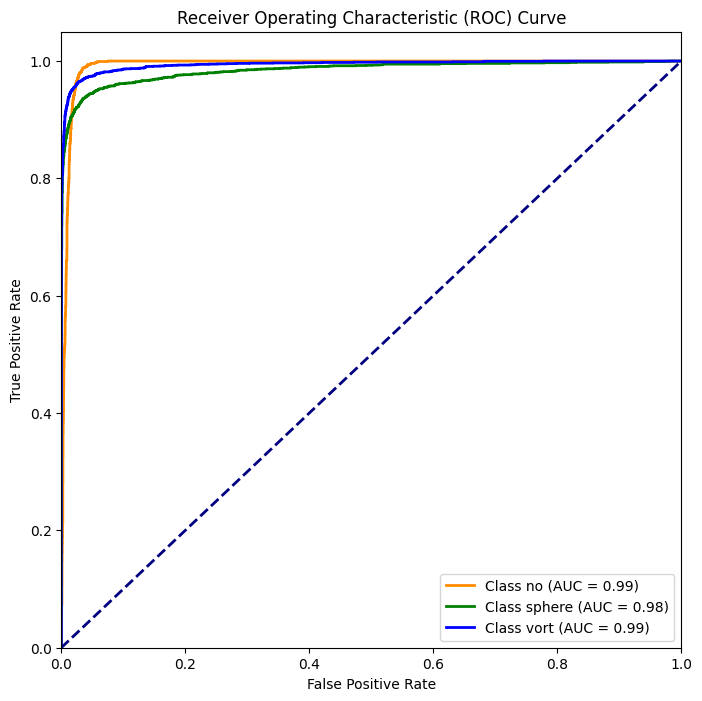

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.plot(fpr[0], tpr[0], color='darkorange', lw=2, label='Class no (AUC = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1], color='green', lw=2, label='Class sphere (AUC = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2], color='blue', lw=2, label='Class vort (AUC = %0.2f)' % roc_auc[2])
# plt.plot(fpr_micro, tpr_micro, color='gray', lw=2, linestyle='--', label='Micro-Averaged ROC (AUC = %0.2f)' % roc_auc_micro)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()